In [1]:

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import warnings
warnings.filterwarnings("ignore")


import gc
import os

import warnings
import pickle

#import pyarrow as pa

from xgboost import XGBClassifier

# from lightgbm import LGBMClassifier
# from lightgbm import early_stopping
# from lightgbm import log_evaluation

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score


import matplotlib.pyplot as plt
# from colorama import Fore, Back, Style


In [2]:

# Set max display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
dtypes={'session_id':'category', 
'elapsed_time':np.int32,
    'index':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'page':'category',
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
     'text':'category',
     'fqid':'category',
     'room_fqid':'category',
     'text_fqid':'category',
     'fullscreen':'category',
     'hq':'category',
     'music':'category',
     'level_group':'category'}
work_path = 'data/predict-student-performance-from-game-play/'
train_df=pd.read_csv(work_path+'train.csv', dtype=dtypes)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      category
 1   index           int32   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            category
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(12), float32(5), int32(2), uint8(1)
memory usage: 1.1 GB


In [26]:
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


### Feature engineering

In [8]:
# # Load your data
# df = df

# # Empty lists to hold column names
# continuous_vars = []
# discrete_vars = []
# categorical_vars = []

# # Define a threshold for the maximum number of unique values a variable can have to be considered categorical/discrete
# threshold = 10

# # Iterate over columns in DataFrame and determine their variable type
# for column in df.columns:
#     if pd.api.types.is_categorical_dtype(df[column]):
#         categorical_vars.append(column)
#     elif np.issubdtype(df[column].dtype, np.integer):
#         if df[column].nunique() <= threshold:
#             discrete_vars.append(column)
#         else:
#             continuous_vars.append(column)
#     elif np.issubdtype(df[column].dtype, np.floating):
#         continuous_vars.append(column)
#     else:
#         print(f'Variable type of {column} is not clearly identifiable')

# print(f'Continuous variables: {continuous_vars}')
# print(f'Discrete variables: {discrete_vars}')
# print(f'Categorical variables: {categorical_vars}')

In [9]:
CATEGORICAL = [ 'event_name', 'name', 'text', 'fqid', 'room_fqid', 'text_fqid', 'text_value']
NUMERICAL = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'time_diff', 'room_coor_x_diff', 'room_coor_y_diff', 'screen_coor_x_diff', 'screen_coor_y_diff']

In [33]:
# def feature_engineer(dataset_df):
#     dfs = []
#     for c in CATEGORICAL:
#         tmp = dataset_df.groupby(['session_id','level'])[c].agg('nunique')
#         tmp.name = tmp.name + '_nunique'
#         dfs.append(tmp)
#     for c in NUMERICAL:
#         tmp = dataset_df.groupby(['session_id','level'])[c].agg('mean')
#         tmp.name = tmp.name + '_mean'
#         dfs.append(tmp)
#     for c in NUMERICAL:
#         tmp = dataset_df.groupby(['session_id','level'])[c].agg('std')
#         tmp.name = tmp.name + '_std'
#         dfs.append(tmp)
#     dataset_df = pd.concat(dfs,axis=1)
#     dataset_df = dataset_df.fillna(-1)
#     dataset_df = dataset_df.reset_index()
#     dataset_df = dataset_df.set_index(['session_id', 'level'])
#     # Unstack level and level_group from index
#     dataset_df = dataset_df.unstack('level')

#     # Concatenate column names
#     dataset_df.columns = ['_'.join(map(str, col)) for col in dataset_df.columns]
#     return dataset_df



def feature_engineer(df, gr):

    #selecting the group
    df = df.query(f'level_group == "{gr}"') #"0-4"

    #generating new coloumns
    df = df[['session_id', 'elapsed_time', 'event_name', 'name', 'level',
    'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
    'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
    'level_group']]
    df['time_diff'] = df['elapsed_time'] - df['elapsed_time'].shift(1)
    df['room_coor_x_diff'] = df['room_coor_x'] - df['room_coor_x'].shift(1)
    df['room_coor_y_diff'] = df['room_coor_y'] - df['room_coor_y'].shift(1)
    df['screen_coor_x_diff'] = df['screen_coor_x'] - df['screen_coor_x'].shift(1)
    df['screen_coor_y_diff'] = df['screen_coor_y'] - df['screen_coor_y'].shift(1)

    # text Not nan
    df['text_value'] = df['text'].isna().astype('int')

    
    # Define aggregation operations for numerical and categorical columns
    agg_numerical = {num_col: ['mean', 'median', 'std', 'sum', 'min', 'max'] for num_col in NUMERICAL}
    agg_categorical = {cat_col: ['nunique','count'] for cat_col in CATEGORICAL}  # 'lambda x:x.value_counts().index[0] if x.nunique() else None' will compute mode

    agg_dict = {**agg_numerical, **agg_categorical}

    # Perform groupby operation for ['session_id', 'level']
    df_level = df.groupby(['session_id', 'level']).agg(agg_dict)
    df_level.columns = ['_'.join(col).strip() for col in df_level.columns.values]
    df_level = df_level.fillna(-1)
    df_level = df_level.unstack('level')
    df_level.columns = ['_'.join(map(str, col)) for col in df_level.columns]

    

    # Perform groupby operation for ['session_id', 'level_group']
    df_level_group = df.groupby(['session_id']).agg(agg_dict)
    df_level_group.columns = ['_'.join(col).strip() for col in df_level_group.columns.values]
    df_level_group = df_level_group.fillna(-1)

    # Concatenate the two resulting dataframes
    df_final = pd.concat([df_level, df_level_group], axis=1)

    return df_final

In [ ]:
#feature generation no split
df1_features = feature_engineer(train_df, gr = "0-4" )
print(df1_features.shape)
df2_features = feature_engineer(train_df, "5-12" )
print(df2_features.shape)
df3_features = feature_engineer(train_df, "13-22")
print(df3_features.shape)

### Possible additional features

In [ ]:
df.head(5)#.groupby(['session_id','text_fqid'])['time_diff'].count()


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,time_diff,room_coor_x_diff,room_coor_y_diff,screen_coor_x_diff,screen_coor_y_diff
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0.0,NaN,NaN,NaN,NaN
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,1323.0,0.0,0.0,0.0,0.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,-492.0,0.0,0.0,0.0,0.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,316.0,0.0,0.0,0.0,0.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,716.0,1.0,0.0,1.0,0.0


In [ ]:
df.groupby(['session_id','room_fqid'])['time_diff'].sum()

session_id         room_fqid                   
20090312431273200  tunic.capitol_0.hall            32422.0
                   tunic.capitol_1.hall                0.0
                   tunic.capitol_2.hall                0.0
                   tunic.drycleaner.frontdesk          0.0
                   tunic.flaghouse.entry               0.0
                                                    ...   
22100221145014656  tunic.humanecology.frontdesk        0.0
                   tunic.kohlcenter.halloffame     57931.0
                   tunic.library.frontdesk             0.0
                   tunic.library.microfiche            0.0
                   tunic.wildlife.center               0.0
Name: time_diff, Length: 447678, dtype: float64

In [ ]:

# time between text values 
df.groupby(['session_id','text_value'])['time_diff'].mean()

session_id         text_value
20090312431273200  0             1082.852459
                   1             1250.543689
20090312433251036  0            -1525.262295
                   1             1691.448718
20090312455206810  0            -2356.868421
                                    ...     
22100217104993650  1             2159.809160
22100219442786200  0            -5732.377049
                   1             1242.858491
22100221145014656  0              -67.319444
                   1             1785.431655
Name: time_diff, Length: 47124, dtype: float64

In [ ]:
# averange coordinate distance between text values 
df.groupby(['session_id','text_value'])['room_coor_x'].mean()

session_id         text_value
20090312431273200  0              82.651031
                   1             -41.733669
20090312433251036  0            -128.311600
                   1             -44.912571
20090312455206810  0            -184.254013
                                    ...    
22100217104993650  1              11.843848
22100219442786200  0             -28.325773
                   1             -70.563507
22100221145014656  0               8.662521
                   1              -7.010103
Name: room_coor_x, Length: 47124, dtype: float32

### Train labels 

In [38]:
train_label = pd.read_csv(work_path+'train_labels.csv')
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]) )
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( 'shape of label dataset is:',train_label.shape )


shape of label dataset is: (424116, 4)


In [52]:
train_label

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


### Split Test/Valid sets

In [75]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

21037556 examples in training, 5259390 examples in testing.


In [76]:
valid_x.session_id.nunique()

4748

<Axes: xlabel='q', ylabel='count'>

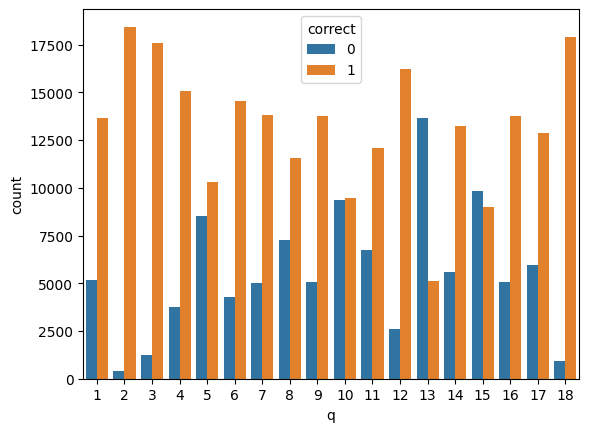

In [77]:
# check for distribution consistency

# TRAIN DATA
train_users = train_x.session_id.unique().astype('int')
train_y = train_label.set_index('session').loc[train_users]
train_y.reset_index(inplace=True)
sns.countplot(x = train_y['q'],hue=train_y['correct'])


<Axes: xlabel='q', ylabel='count'>

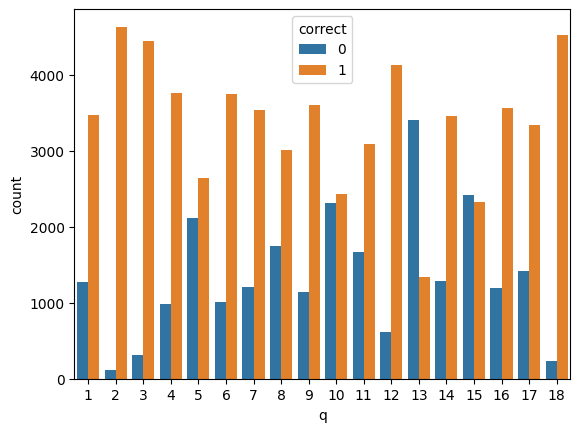

In [78]:
# Validation DATA
valid_users = valid_x.session_id.unique().astype('int')
valid_y = train_label.set_index('session').loc[valid_users]
valid_y.reset_index(inplace=True)
#valid_y.head(50)
sns.countplot(x = valid_y['q'],hue=valid_y['correct'])

<Axes: xlabel='q', ylabel='count'>

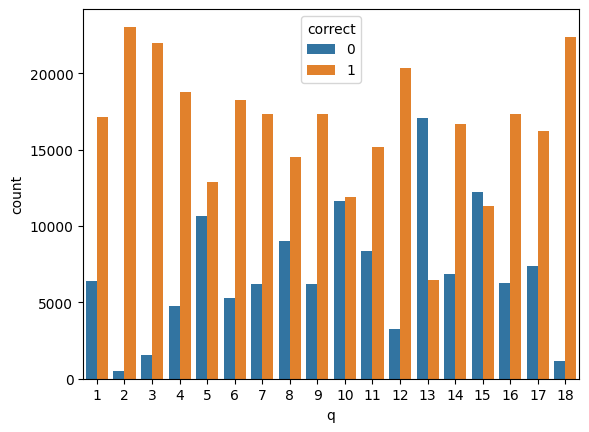

In [79]:
sns.countplot(x = train_label['q'],hue=train_label['correct'])

In [82]:
df1_train, df1_valid = split_dataset(df1_features)
print("{} examples in training, {} examples in testing.".format(
    len(df1_train), len(df1_valid)))

df2_train, df2_valid = split_dataset(df2_features)
print("{} examples in training, {} examples in testing.".format(
    len(df2_train), len(df2_valid)))

df3_train, df3_valid = split_dataset(df3_features)
print("{} examples in training, {} examples in testing.".format(
    len(df3_train), len(df3_valid)))

18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.


### XGBoost model

To do.

- Cross validation /
- Grid search / parameter optimization
- augentation / solving data imbalances

In [39]:
#estimators_xgb = [498, 448, 378, 364, 405, 495, 456, 249, 384, 405, 356, 262, 484, 381, 392, 248 ,248, 345]

xgb_params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
        }

In [40]:
warnings.filterwarnings("ignore")
train_label = pd.read_csv(work_path+'train_labels.csv')
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]))
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     


In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [85]:

# with validation

warnings.filterwarnings("ignore")
train_label = pd.read_csv(work_path+'train_labels.csv')
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]))
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = df1_train.columns

    elif t<=13: 
        grp = '5-12'
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = df2_train.columns

    elif t<=22: 
        grp = '5-12'
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = df3_train.columns
        
    xgb_params['n_estimators'] = 300 #estimators_xgb[t-1]
     
    # TRAIN DATA
    train_users = df_train.index.values.astype('int')
    train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
    
    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]

    clf =  XGBClassifier(**xgb_params)
    clf.fit(df_train[FEATURES].astype('float32'), train_y['correct'], verbose = 0)
    #clf.save_model(f'XG_boost_models/XGB_question{t}.xgb')

    #Evaluating the model
    print(f' XGB model evaluation for question {t}')
    # Variables
    X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    y_train = train_y['correct']
    y_val = valid_y['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_preds)
    val_accuracy = accuracy_score(y_val, y_val_preds)

    train_precision = precision_score(y_train, y_train_preds)
    val_precision = precision_score(y_val, y_val_preds)

    train_recall = recall_score(y_train, y_train_preds)
    val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Validation Precision: {val_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")


    
    #print(f'model XGB saved for question {t}')
    #print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')

 XGB model evaluation for question 1
Training Accuracy: 0.7722956124993369
Validation Accuracy: 0.7542966263526416
Training Precision: 0.7792038027332145
Validation Precision: 0.7659475759684528
Training Recall: 0.9579254930606282
Validation Recall: 0.9568241089539264
Training F1 Score: 0.8593709043250329
Validation F1 Score: 0.8508116464828653
Training AUC Score: 0.6188154311591181
Validation AUC Score: 0.5786497723850456
 XGB model evaluation for question 2
Training Accuracy: 0.9798397792986365
Validation Accuracy: 0.9755994058985784
Training Precision: 0.9798355001326612
Validation Precision: 0.9755994058985784
Training Recall: 1.0
Validation Recall: 1.0
Training F1 Score: 0.9898150629857948
Validation F1 Score: 0.9876490172913758
Training AUC Score: 0.5052083333333333
Validation AUC Score: 0.5
 XGB model evaluation for question 3
Training Accuracy: 0.9345853891453128
Validation Accuracy: 0.9354975599405898
Training Precision: 0.9346221254447926
Validation Precision: 0.9356551284773

In [41]:
# warnings.filterwarnings("ignore")
# train_label = pd.read_csv(work_path+'train_labels.csv')
# train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]))
# train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
# pred_xgb = np.zeros((df1_features.shape[0],18))     

# for t in range(1,19):
#     # USE THIS TRAIN DATA WITH THESE QUESTIONS
#     if t<=3: 
#         grp = '0-4'
#         df = df1_features
#         FEATURES = df1_features.columns

#     elif t<=13: 
#         grp = '5-12'
#         df = df2_features
#         FEATURES = df2_features.columns

#     elif t<=22: 
#         grp = '13-22'
#         df = df3_features
#         FEATURES = df3_features.columns
        
#     xgb_params['n_estimators'] = 300 #estimators_xgb[t-1]
     
#     # TRAIN DATA
#     train_users = df.index.values.astype('int')
#     train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
    
#     # Validation DATA
#     valid_users = valid_df.index.values.astype('int')
#     valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]

#     clf =  XGBClassifier(**xgb_params)
#     clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose = 0)
#     clf.save_model(f'XG_boost_models/XGB_question{t}.xgb')


    
#     print(f'model XGB saved for question {t}')
#     #print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')

model XGB saved for question 1
model XGB saved for question 2
model XGB saved for question 3
model XGB saved for question 4
model XGB saved for question 5
model XGB saved for question 6
model XGB saved for question 7
model XGB saved for question 8
model XGB saved for question 9
model XGB saved for question 10
model XGB saved for question 11
model XGB saved for question 12
model XGB saved for question 13
model XGB saved for question 14
model XGB saved for question 15
model XGB saved for question 16
model XGB saved for question 17
model XGB saved for question 18


### Submission

In [ ]:
# import jo_wilder
# env = jo_wilder.make_env()
# iter_test = env.iter_test()

In [ ]:
# limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

# count = 0

# for (sample_submission, test) in iter_test:
        
#         session_id = test.session_id.values[0]
#         gr = test.level_group.values[0]
#         a,b = limits[grp]
  

#         # ------------------- level 0-4 ---------------------------------
#         if a == 1:
#             test = feature_engineer(test, gr)
            

#         # ------------------- level 5-12 ---------------------------------
#         elif a == 4:
#             test = feature_engineer(test, gr)

#         # ------------------- level 13-22 ---------------------------------    
#         elif a == 14:
#             test = feature_engineer(test, gr)
    
#         for t in range(a,b):

#             clf = XGBClassifier()
#             clf.load_model(f'/kaggle/working/XGB_question{t}.xgb')
#             mask = sample_submission.session_id.str.contains(f'q{t}')
#             p = clf.predict_proba(test.astype('float32'))[:,1]
#             sample_submission.loc[mask,'correct'] = int((p.item())>0.625)  
                
#         env.predict(sample_submission)